In [40]:
import networkx as nx
from networkx.convert_matrix import to_numpy_array
import numpy as np
from utils import get_graph, get_bc_info, clean_adj_matrix
from GNN_BC import GNN_BC
from GNN_BC_2 import GNN_BC_2
import tensorflow as tf
import keras
from tensorflow.keras.callbacks import History


#Prevents warnings from popping up
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [41]:
file = "email.txt"

file_tokens = file.split(".")
file_name = file_tokens[0]
file_type = file_tokens[1]

g = get_graph("graphs/"+file, file_type)
info_dict = get_bc_info(g)


In [45]:
import importlib
import utils
importlib.reload(utils)
from utils import *
import importlib
import GNN_layers
importlib.reload(GNN_layers)
from GNN_layers import *
import importlib
import GNN_BC
importlib.reload(GNN_BC)
from GNN_BC import *
import importlib
import GNN_BC_2
importlib.reload(GNN_BC_2)
from GNN_BC_2 import *
from scipy.stats import kendalltau as kt

real_BCs = dict(sorted(info_dict['BC_dict'].items())) #sorted real BC values dictionary

adj_matrix = to_numpy_array(g)
#adj_matrix = clean_adj_matrix(adj_matrix, real_BCs)
adj_matrix_t = np.transpose(adj_matrix)

#adj_matrix = np.reshape(adj_matrix, (1, adj_matrix.shape[0], adj_matrix.shape[1]))
#adj_matrix_t = np.reshape(adj_matrix_t, (1, adj_matrix_t.shape[0], adj_matrix_t.shape[1]))

num_nodes = adj_matrix.shape[0]

#flat_adj_matrix = np.reshape(np.ndarray.flatten(adj_matrix), (1, adj_matrix.shape[0]**2))
#flat_adj_matrix_t = np.reshape(np.ndarray.flatten(adj_matrix_t), (1, adj_matrix.shape[0]**2))

params = {
    'num_epochs': 7,
    'learning_rate' : 0.0001,
    'n_messaging_cells': 3,
    'hidden_neurons_messaging_cells': 20,
    'mlp_hidden_layers': [30,30,30],
    'GNN_layer_activation': tf.keras.activations.swish,
    'mlp_activation': tf.keras.activations.swish,
    'pairs_sample_size': 1*num_nodes,
    'margin': 1
}



optimizer = keras.optimizers.Adam(params['learning_rate'])

#gnn = GNN_BC(adj_matrix.shape, num_nodes, params, real_BCs)
#gnn.compile(optimizer)

#gnn2 = GNN_BC_2(adj_matrix.shape, num_nodes, params, real_BCs)
#gnn2.compile(optimizer)

models = ['gnn']
avg_kt_scores = []
avg_times = []
#hist = History()
for model in models:
    kt_scores = []
    times = []
    for _ in range(1):
        if model == 'gnn':
            gnn = GNN_BC(num_nodes, num_nodes, params)
        else:
            gnn = GNN_BC_2(num_nodes, 1, params)
        gnn.compile(optimizer)
        
        start_time = time.time()
        for _ in range(params['num_epochs']):
            gnn.real_BCs = real_BCs
            gnn.fit(x=(adj_matrix,adj_matrix_t), epochs= params['num_epochs'], batch_size=1, verbose=True)
            end_time = time.time() - start_time
            times.append(end_time)
            
        print('time:', end_time)
        
        scores = np.asarray(list(itertools.chain.from_iterable(model.call((adj, adj_t)))))
        N= len(real_BCs)
        top_predicted = scores.argsort()[-N:][::-1]
        top_real = np.asarray(list(real_BCs.values())).argsort()[-N:][::-1]

        kt_score = kt(top_predicted, top_real).correlation
        kt_scores.append(kt_score)
        print(kt(top_predicted, top_real).correlation)
        
    avg_kt_scores.append(sum(kt_scores)/len(kt_scores))
    avg_times.append(sum(times)/len(times))

Epoch 1/7
(1005,)
calculating grads...
finished
(1005,)
calculating grads...
finished
1005/1005 [==============================] - 111s 111ms/step - loss: 280.5421
Epoch 2/7
1005/1005 [==============================] - 108s 108ms/step - loss: 0.1370
Epoch 3/7
1005/1005 [==============================] - 101s 100ms/step - loss: 1.7286e-04
Epoch 4/7
1005/1005 [==============================] - 101s 101ms/step - loss: 5.2414e-05
Epoch 5/7
1005/1005 [==============================] - 106s 105ms/step - loss: 2.9060e-05
Epoch 6/7
1005/1005 [==============================] - 106s 106ms/step - loss: 2.2389e-05
Epoch 7/7
1005/1005 [==============================] - 107s 106ms/step - loss: 0.0000e+00
time: 815.3106381893158


NameError: name 'itertools' is not defined

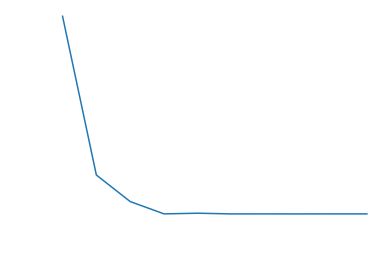

In [9]:
#PLOT LOSS
import matplotlib.pyplot as plt

with plt.rc_context({'axes.edgecolor':'white', 'xtick.color':'white', 'ytick.color':'white','axes.labelcolor':'white'}):
    plt.plot(hist.history['loss'])
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()

In [47]:
scores = gnn.call((adj_matrix,adj_matrix_t))

N= int(0.1*len(real_BCs))
top_predicted = scores.numpy()[0].argsort()[-N:][::-1]
top_real = np.asarray(list(real_BCs.values())).argsort()[-N:][::-1]

overlap = set(top_predicted) & set(top_real)
universe = set(top_predicted) | set(top_real)

print(len(overlap)/len(universe))

0.19760479041916168


In [48]:
from scipy.stats import kendalltau as kt

N= len(real_BCs)
top_predicted = scores.numpy()[0].argsort()[-N:][::-1]
top_real = np.asarray(list(real_BCs.values())).argsort()[-N:][::-1]

print(kt(top_predicted, top_real).correlation)

0.17961586489861453


In [8]:
#KT para a versao alternativa, variando com o tamnho do sampling
{1:0.16, 2:0.231, 3:0.244, 4:0.258, 5:0.273, 10: 0.276, 20: 0.287}

{1: 0.14, 2: 0.231, 3: 0.244, 4: 0.258, 5: 0.273}

Results based on averaging 3 runs

              original  alternative
Running time: 31min     38min
    KT score: 0.23      0.28

In [28]:
avg_kt_scores

[0.2274272726672085, 0.28093661836897854]

In [27]:
2324/60


38.733333333333334

In [36]:
real_BCs = dict(sorted(info_dict['BC_dict'].items()))

{0: 0.0010981319361456903,
 1: 0.00116845975844197,
 2: 0.006569728906242246,
 3: 0.0016536011953476445,
 4: 0.00554765465064756,
 5: 0.030995032082719885,
 6: 0.012386430673860313,
 7: 0.002817732994937317,
 8: 0.00055682927630677,
 9: 0.000280313990211159,
 10: 0.0010841326165955513,
 11: 0.003946219690662467,
 12: 0.00471512629386701,
 13: 0.02356548465072998,
 14: 0.0037259814036694275,
 15: 0.0022165861563252644,
 16: 0.001490203835316398,
 17: 0.005222506021239661,
 18: 0.0030762388706982407,
 19: 0.0036326648413009303,
 20: 0.003890099824944286,
 21: 0.011597349708744757,
 22: 5.491758344417408e-05,
 23: 0.003255805564807038,
 24: 0.001529867899170945,
 25: 0.00021776774030606615,
 26: 0.0002448031785835666,
 27: 0.0031169045886995173,
 28: 0.00512085356146593,
 29: 0.0014187487678658255,
 30: 0.0016935074003145438,
 31: 0.00039868505547029965,
 32: 0.00013100040938629414,
 33: 0.0002306047334583447,
 34: 0.00011527072694880684,
 35: 0.0014145768338236653,
 36: 0.000397955841220

In [38]:
real_BCs = info_dict['BC_dict']
real_BCs

{5: 0.030995032082719885,
 7: 0.002817732994937317,
 8: 0.00055682927630677,
 9: 0.000280313990211159,
 10: 0.0010841326165955513,
 11: 0.003946219690662467,
 12: 0.00471512629386701,
 13: 0.02356548465072998,
 14: 0.0037259814036694275,
 15: 0.0022165861563252644,
 16: 0.001490203835316398,
 17: 0.005222506021239661,
 18: 0.0030762388706982407,
 19: 0.0036326648413009303,
 20: 0.003890099824944286,
 21: 0.011597349708744757,
 22: 5.491758344417408e-05,
 23: 0.003255805564807038,
 24: 0.001529867899170945,
 25: 0.00021776774030606615,
 26: 0.0002448031785835666,
 27: 0.0031169045886995173,
 28: 0.00512085356146593,
 29: 0.0014187487678658255,
 30: 0.0016935074003145438,
 31: 0.00039868505547029965,
 32: 0.00013100040938629414,
 33: 0.0002306047334583447,
 34: 0.00011527072694880684,
 35: 0.0014145768338236653,
 36: 0.00039795584122069355,
 37: 0.0003954545544527311,
 38: 0.0028223677775490695,
 39: 0.00023551590149263756,
 40: 0.0012697616047596333,
 41: 0.0034346077493397163,
 42: 0.0